In [292]:

import torch
import torch.nn as nn 
from torch import nn, Tensor
from torch.utils.data import Dataset,DataLoader
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import math

from sklearn.preprocessing import MinMaxScaler

In [293]:


# DOes basic positional encoding with dropout
class PositionalEncoder(nn.Module):
    def __init__(
        self, 
        dropout: float=0.1, 
        max_seq_len: int=5000, 
        d_model: int=256,
        ):

        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)

        # adapted from PyTorch tutorial
        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe = torch.zeros(max_seq_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[:x.size(0)]

        return self.dropout(x)

In [294]:
# Basic transformer for time series data inspired by the influenza paper
class TimeSeriesTransformer(nn.Module):

    def __init__(self, 
        input_size: int, 
        dim_val: int=256,  
        num_enc_layers: int=4,
        num_dec_layers: int=4,
        attn_heads: int=8,
        dropout_pos_enc: float=0.1,
        num_predicted_features: int=1
        ): 

        super().__init__() 

        self.input_linear = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )


        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=attn_heads,
            )
        
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=num_enc_layers, 
            )

        self.decoder_input_layer = nn.Linear(
            in_features=num_predicted_features,
            out_features=dim_val
            )     

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=attn_heads,
            )

        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=num_dec_layers, 
            )
        
        self.output_linear = nn.Linear(
            in_features=dim_val, 
            out_features=num_predicted_features
            )

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, 
                tgt_mask: Tensor=None) -> Tensor:
        src = self.input_linear(src) 
        src = self.positional_encoding_layer(src) 

        src = self.encoder(src)

        decoder_output = self.decoder_input_layer(tgt) 
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=src_mask
            )

        decoder_output = self.output_linear(decoder_output) 
        return decoder_output

In [295]:
def generate_square_subsequent_mask(dim1: int, dim2: int) -> Tensor:
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)

In [296]:
# Dataloader for the transformer,returns a 3 tuple of input,decoder input (for training) and ground truth output.
class TransformerDataset(Dataset):
    def __init__(self, 
        data: torch.tensor,
        input_len: int, 
        output_len:int
        ):
        
        super().__init__()
        print("Transformer Dataset: data shape={}".format(data.size(),data.shape))
        self.data = data
        self.inp_len = input_len
        self.op_len = output_len

    # Overriden fucntions required for DataLoader to work
    def __len__(self):
        return len(self.data)-(self.inp_len+self.op_len)+1

    def __getitem__(self, index):
        sequence = self.data[index:index+self.inp_len+self.op_len]
        src, dec_src, tgt = self.get_tuple(
            sequence=sequence,
            enc_seq_len=self.inp_len,
            target_seq_len=self.op_len
            )
        return src, dec_src, tgt
    
    def get_tuple(
        self,
        sequence: torch.Tensor, 
        enc_seq_len: int, 
        target_seq_len: int
        ): 
        # encoder input
        src = sequence[:enc_seq_len] 
        
        # decoder input. The last element of the encoder input is used as the first element of the decoder input
        dec_src = sequence[enc_seq_len-1:len(sequence)-1]
        
        #the ground truth
        tgt = sequence[-target_seq_len:]
        return src, dec_src, tgt

In [297]:
test_size = 0.1
batch_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

dim_val = 256
attn_heads = 8
input_len = 30 # length of input given to encoder

output_sequence_length = 1 # target sequence length. If hourly data and length = 48, you predict 2 days ahead

cuda


In [298]:
# Generate masks outside and then use them in the training loop

src_mask = generate_square_subsequent_mask(
    dim1=output_sequence_length,
    dim2=input_len
    ).to(device)

tgt_mask = generate_square_subsequent_mask( 
    dim1=output_sequence_length,
    dim2=output_sequence_length
    ).to(device)


def train_epoch(
    model : TimeSeriesTransformer,
    train_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    device: torch.device):

    # print("From train_epoch() ")
    running_loss = 0
    model.train()
    for i, data in enumerate(train_loader):
        src, dec_src, tgt = data
        optimizer.zero_grad()
        src = src.permute(1, 0, 2).to(device)
        dec_src = dec_src.permute(1, 0, 2).to(device)
        tgt = tgt.permute(1, 0,2).to(device)
        # print("src.shape={}, dec_src.shape={}, tgt.shape={}".format(src.shape,dec_src.shape,tgt.shape))
        output = model(
            src=src,
            tgt=dec_src,
            src_mask=src_mask,
            tgt_mask=tgt_mask
            )
        # Compute the loss and its gradients
        loss = loss_fn(output, tgt)
        loss.backward()
        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        # if(i==5):
        #     print("Batch: {}, Loss: {}".format(i, loss.item()))

    return running_loss / len(train_loader)



In [299]:
def inference_epoch(
    model: nn.Module, 
    src: torch.Tensor, 
    forecast_window: int,
    batch_size: int,
    device,
    ) -> torch.Tensor:

    # last value of the encoder input is used as the first value of the decoder input
    tgt = src[-1, :, 0] 

    if batch_size == 1:
        tgt = tgt.unsqueeze(0).unsqueeze(0) 

    if batch_size > 1:
        tgt = tgt.unsqueeze(0).unsqueeze(-1)

    # Iteratively generate the output
    for _ in range(forecast_window-1):
        # This is a lazy implementation not particularly efficient
        tgt_mask =generate_square_subsequent_mask(
            dim1=tgt.shape[0],
            dim2=tgt.shape[0],
            ).to(device)

        src_mask =generate_square_subsequent_mask(
            dim1=tgt.shape[0],
            dim2=src.shape[0],
            ).to(device)

        # Make prediction
        pred = model(src, tgt, src_mask, tgt_mask) 
        last_predicted_value = pred[-1].unsqueeze(0)

        # Update generated output
        tgt = torch.cat((tgt, last_predicted_value.detach()), 0)

    tgt_mask =generate_square_subsequent_mask(
            dim1=tgt.shape[0],
            dim2=tgt.shape[0],
            ).to(device)

    src_mask =generate_square_subsequent_mask(
        dim1=tgt.shape[0],
        dim2=src.shape[0],
        ).to(device)

    pred = model(src, tgt, src_mask, tgt_mask)

    return pred

In [300]:
def predict(
    model: TimeSeriesTransformer,
    test_loader: DataLoader,
    device: torch.device        
):
    actual=[]
    pred=[]
    with torch.no_grad():
        for i, (src, _, tgt) in enumerate(test_loader):
            src=src.permute(1,0,2).to(device)
            tgt=tgt.permute(1,0,2).to(device)
            prediction = inference_epoch(
                model=model, 
                src=src, 
                forecast_window=1,
                batch_size=src.shape[1],
                device=device
                )
            actual.extend(tgt.squeeze().cpu().tolist())
            pred.extend(prediction.squeeze().squeeze().cpu().tolist())
    plt.figure(figsize=(16,8))
    plt.plot(min_max_scalar.inverse_transform(np.array(actual).reshape(-1,1)), color='blue', label='Actual Price')
    plt.plot(min_max_scalar.inverse_transform(np.array(pred).reshape(-1,1)) , color='red', label='Predicted Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


def fit(
    model: TimeSeriesTransformer,
    n_epochs: int,
    train_loader: DataLoader,
    test_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    device: torch.device
    ):

    best_valid_loss = float('inf')
    loss_over_time = []
    for epoch in range(n_epochs):
        loss = train_epoch(
            model=model,
            train_loader=train_loader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            device=device
            )
        print("Epoch: {}, Loss: {}".format(epoch+1, loss))
        loss_over_time.append(loss)
        with torch.no_grad():
            loss_val = 0
            for i, (src, _, tgt_y) in enumerate(test_loader):
                src=src.permute(1,0,2).to(device)
                tgt_y=tgt_y.permute(1,0,2).to(device)
                prediction = inference_epoch(
                    model=model, 
                    src=src, 
                    forecast_window=1,
                    batch_size=src.shape[1],
                    device=device
                    )
                loss_val += loss_fn(tgt_y, prediction)
            loss_val = loss_val.item()/len(test_loader)
            print("Validation Loss: {}".format(loss_val))

            if loss_val < best_valid_loss:
                best_valid_loss = loss_val
                print(f"Best validation loss: {best_valid_loss}")
                print(f"Saving best model for epoch: {epoch+1}\n")
                torch.save({
                    'epoch': epoch+1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss_val,
                    }, 'outputs/best_model.pth')
    return loss_over_time


                                Close
Date                                 
2022-05-06 00:00:00-04:00  126.464012
2022-05-09 00:00:00-04:00  124.995018
2022-05-10 00:00:00-04:00  120.058067
2022-05-11 00:00:00-04:00  121.564255
2022-05-12 00:00:00-04:00  123.563210


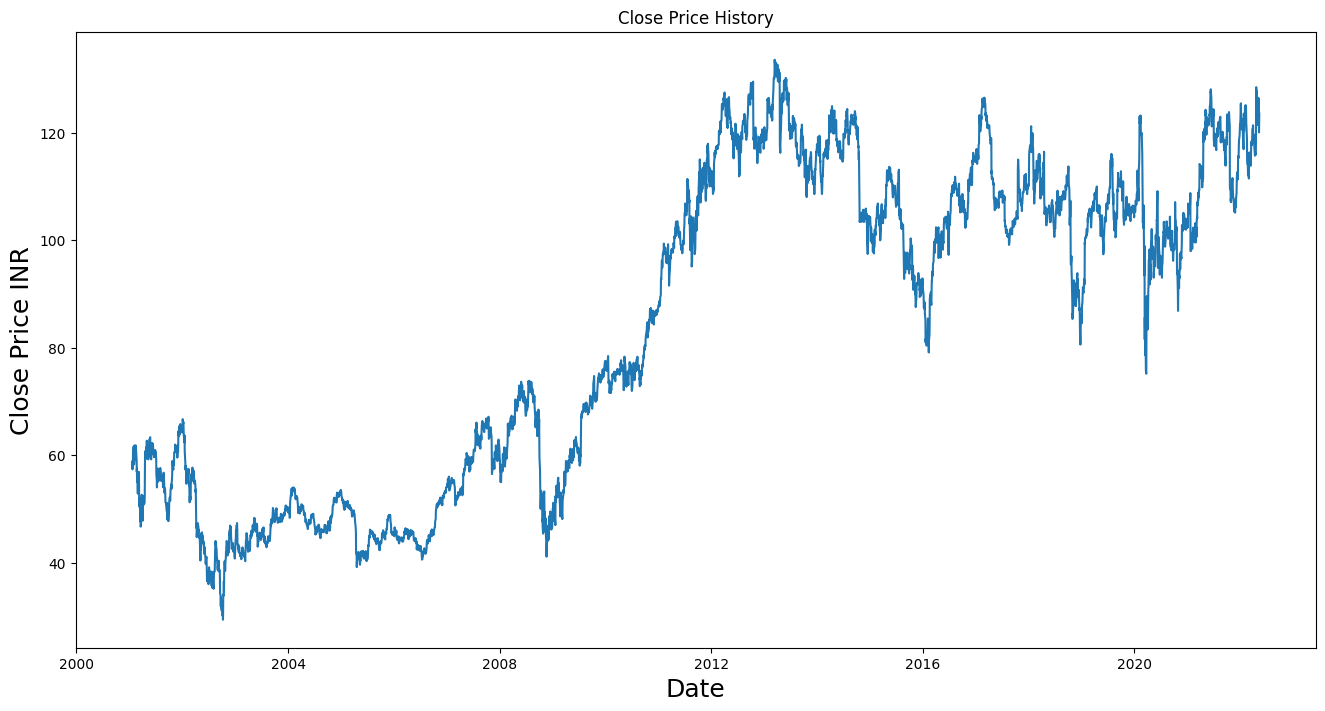

Transformer Dataset: data shape=torch.Size([4827, 1])
Transformer Dataset: data shape=torch.Size([536, 1])


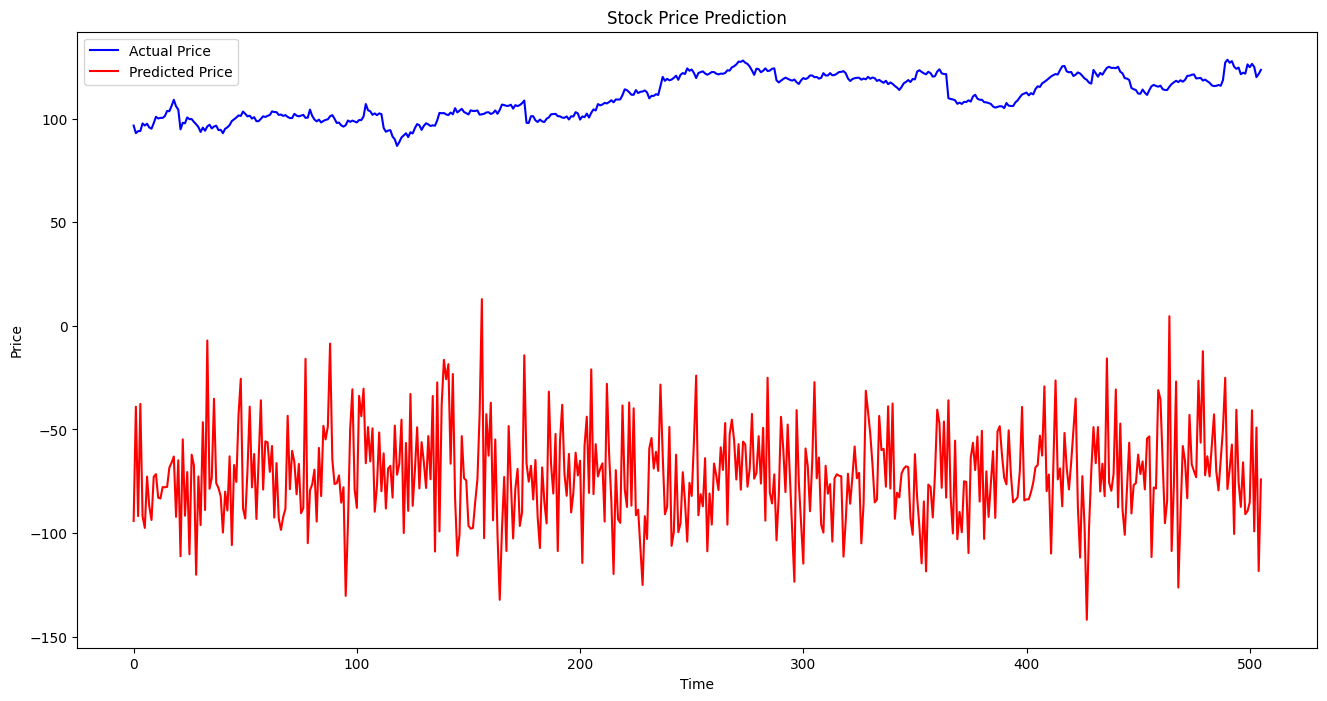

11576577
Epoch: 1, Loss: 0.3750050254656296
Validation Loss: 0.12421278655529022
Best validation loss: 0.12421278655529022
Saving best model for epoch: 1

Epoch: 2, Loss: 0.03788315955745546
Validation Loss: 0.05517560988664627
Best validation loss: 0.05517560988664627
Saving best model for epoch: 2

Epoch: 3, Loss: 0.046393171541000665
Validation Loss: 0.04849664866924286
Best validation loss: 0.04849664866924286
Saving best model for epoch: 3

Epoch: 4, Loss: 0.046634885470235816
Validation Loss: 0.04976077377796173
Epoch: 5, Loss: 0.04837056441771749
Validation Loss: 0.05176827311515808
Epoch: 6, Loss: 0.04822021293895025
Validation Loss: 0.05749811977148056
Epoch: 7, Loss: 0.049620700424144924
Validation Loss: 0.07149824500083923
Epoch: 8, Loss: 0.05003189582279638
Validation Loss: 0.06629467755556107
Epoch: 9, Loss: 0.05293422508494634
Validation Loss: 0.05641275644302368
Epoch: 10, Loss: 0.06115497610727815
Validation Loss: 0.03648994117975235
Best validation loss: 0.036489941179

In [301]:

model = TimeSeriesTransformer(
    input_size=1,
    num_predicted_features=1
    ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

# Loading financial data
import yfinance as yf
apple = yf.Ticker("ibm")
df = apple.history(start='2001-01-19', end='2022-05-13', actions=False)
df = df[['Close']]
print(df[-5:])
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price INR', fontsize=18)
plt.show()
data=df.values

min_max_scalar = MinMaxScaler(feature_range=(0,1))
data = min_max_scalar.fit_transform(data)

training_data = data[:-(round(len(data)*test_size))]
testing_data = data[-(round(len(data)*test_size)):]


# Making dataset
training_data = TransformerDataset(
    data=torch.tensor(training_data).float(),
    input_len=input_len,
    output_len=output_sequence_length
    )

testing_data=TransformerDataset(
    data=torch.tensor(testing_data).float(),
    input_len=input_len,
    output_len=output_sequence_length
    )

# Making dataloader
training_data = DataLoader(training_data, batch_size)
testing_data = DataLoader(testing_data, batch_size)

# Untrained model prediction
predict(model,testing_data,device)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)
training_losses=fit(
    model=model,
    n_epochs=100,
    train_loader=training_data,
    test_loader=testing_data,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device)



Best model was saved at 4 epochs

0.03278343379497528
Inference time taken is  0.1646716594696045


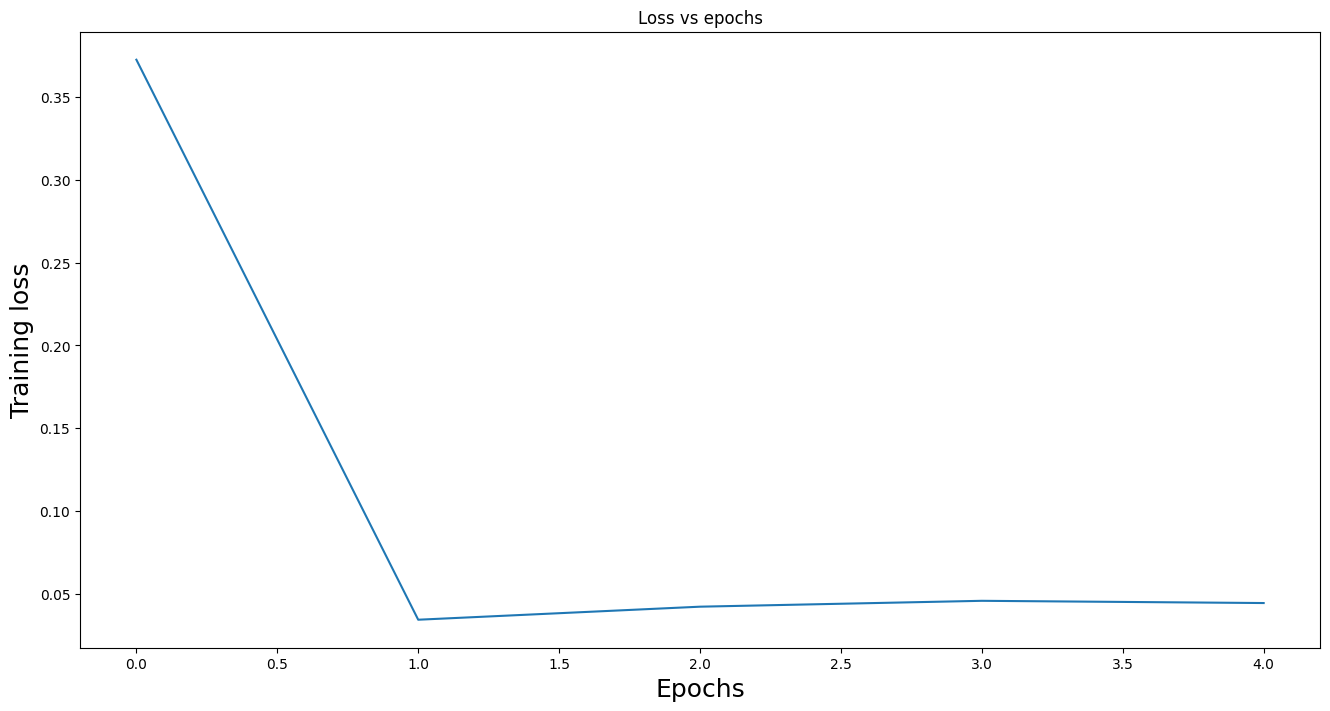

In [ ]:
best_model_cp = torch.load('outputs/best_model.pth')
best_model_epoch = best_model_cp['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")
model.load_state_dict(best_model_cp['model_state_dict'])
print(best_model_cp['loss'])
predict(model,testing_data,device)
# print("Inference time taken is ",end-start)
# print(training_losses)
plt.figure(figsize=(16,8))
plt.title('Loss vs epochs')
plt.plot(training_losses)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Training loss', fontsize=18)
plt.show()